In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
%cd drive/MyDrive/"CIS 520"/
!ls

[Errno 2] No such file or directory: 'drive/MyDrive/CIS 520/'
/content/drive/MyDrive/CIS 520
 char-rnn-generation.ipynb   hw8.ipynb
'Data Exploration.ipynb'     “Info_Gain.ipynb”的副本
 “hw0.ipynb”的副本	     “K_Nearest_Neighbors.ipynb”的副本
 hw10.ipynb		     preProcessed_data.csv
 hw2.ipynb		     r2x.csv
 hw4.ipynb		     r2y.csv
 hw6.ipynb		     r2z.csv
'hw7_2021 (1).ipynb'	     window_200_r2fit.csv
 hw7_2021.ipynb		     window_200_r2fit_idx.csv
'hw8 (1).ipynb'


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

In [104]:
data = pd.read_csv('./preProcessed_data.csv')
# Window width
w = 200
# Sliding window 'stride'
stride = 4 * 20

rolling_data_x = data.groupby('id')['x'].rolling(window=w,min_periods=5, center=True)
rolling_data_y = data.groupby('id')['y'].rolling(window=w,min_periods=5, center=True)
rolling_data_z = data.groupby('id')['z'].rolling(window=w,min_periods=5, center=True)
data['rolling_x_mean']=list(rolling_data_x.mean().fillna(0))
data['rolling_y_mean']=list(rolling_data_y.mean().fillna(0))
data['rolling_z_mean']=list(rolling_data_z.mean().fillna(0))
data['rolling_x_std']=list(rolling_data_x.std().fillna(0))
data['rolling_y_std']=list(rolling_data_y.std().fillna(0))
data['rolling_z_std']=list(rolling_data_z.std().fillna(0))
data['rolling_x_min']=list(rolling_data_x.min().fillna(0))
data['rolling_y_min']=list(rolling_data_y.min().fillna(0))
data['rolling_z_min']=list(rolling_data_z.min().fillna(0))
data['rolling_x_max']=list(rolling_data_x.max().fillna(0))
data['rolling_y_max']=list(rolling_data_y.max().fillna(0))
data['rolling_z_max']=list(rolling_data_z.max().fillna(0))
data['rolling_x_iqr']=np.array(rolling_data_x.quantile(0.75).fillna(0))-np.array(rolling_data_x.quantile(0.25).fillna(0))
data['rolling_y_iqr']=np.array(rolling_data_y.quantile(0.75).fillna(0))-np.array(rolling_data_y.quantile(0.25).fillna(0))
data['rolling_z_iqr']=np.array(rolling_data_z.quantile(0.75).fillna(0))-np.array(rolling_data_z.quantile(0.25).fillna(0))
data['avg_speed'] = np.sqrt(np.square(data['x'])+np.square(data['y'])+np.square(data['z']))
data['rolling_mean_speed'] = list(data.groupby('id')['avg_speed'].rolling(window=w,min_periods=5).mean().fillna(0))
data['abs_x_diff']=np.abs(data.groupby('id')['x'].diff().fillna(0))
data['abs_y_diff']=np.abs(data.groupby('id')['y'].diff().fillna(0))
data['abs_z_diff']=np.abs(data.groupby('id')['z'].diff().fillna(0))
data['rolling_abs_x_diff']=list(data.groupby('id')['abs_x_diff'].rolling(window=w,min_periods=5).mean().fillna(0))
data['rolling_abs_y_diff']=list(data.groupby('id')['abs_y_diff'].rolling(window=w,min_periods=5).mean().fillna(0))
data['rolling_abs_z_diff']=list(data.groupby('id')['abs_z_diff'].rolling(window=w,min_periods=5).mean().fillna(0))

In [105]:
data

,id,class,timestamp,x,y,z,rolling_x_mean,rolling_y_mean,rolling_z_mean,rolling_x_std,rolling_y_std,rolling_z_std,rolling_x_min,rolling_y_min,rolling_z_min,rolling_x_max,rolling_y_max,rolling_z_max,rolling_x_iqr,rolling_y_iqr,rolling_z_iqr,avg_speed,rolling_mean_speed,abs_x_diff,abs_y_diff,abs_z_diff,rolling_abs_x_diff,rolling_abs_y_diff,rolling_abs_z_diff
0,1,Walking,4991922345000,0.69,10.80,-2.030000,3.653800,9.810100,-0.478800,5.535832,3.934435,3.217605,-7.35,2.37,-7.04,19.57,19.23,10.88,6.680,5.0400,2.4875,11.010767,0.000000,0.00,0.00,0.000000,0.00000,0.00000,0.000000
1,1,Walking,4991972333000,6.85,7.44,-0.500000,3.735248,9.819505,-0.461089,5.568572,3.915855,3.206421,-7.35,2.37,-7.04,19.57,19.23,10.88,6.740,4.9700,3.1300,10.125517,0.000000,6.16,3.36,1.530000,0.00000,0.00000,0.000000
2,1,Walking,4992022351000,0.93,5.63,-0.500000,3.821863,9.827647,-0.418627,5.609563,3.897289,3.219200,-7.35,2.37,-7.04,19.57,19.23,10.88,6.785,4.9375,3.1200,5.728159,0.000000,5.92,1.81,0.000000,0.00000,0.00000,0.000000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000,3.850194,9.882816,-0.418252,5.589398,3.918346,3.203383,-7.35,2.37,-7.04,19.57,19.23,10.88,6.720,4.9800,3.1100,5.479808,0.000000,3.04,0.62,0.190000,0.00000,0.00000,0.000000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000,3.841154,9.975288,-0.458750,5.562963,4.011696,3.214436,-7.35,2.37,-7.04,19.57,19.50,10.88,6.655,5.0225,3.1400,6.578351,7.784520,2.48,0.72,1.260000,3.52000,1.30200,0.596000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098203,36,Standing,15049012250000,-0.91,9.43,2.533385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.806683,9.844126,0.00,0.24,0.027241,0.08050,0.05710,0.057342
1098204,36,Standing,15049062268000,-1.18,9.51,2.492524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.901776,9.844506,0.27,0.08,0.040861,0.08165,0.05750,0.057546
1098205,36,Standing,15049112287000,-1.50,9.53,2.533385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.974414,9.845030,0.32,0.02,0.040861,0.08305,0.05740,0.057546
1098206,36,Standing,15049162275000,-2.07,8.77,2.179256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.270758,9.842495,0.57,0.76,0.354129,0.08570,0.06075,0.059112


In [106]:
df_r2x = pd.read_csv("r2x.csv")
df_r2y = pd.read_csv("r2y.csv")
df_r2z = pd.read_csv("r2z.csv")
data['rolling_x_r2'] = df_r2x
data['rolling_y_r2'] = df_r2y
data['rolling_z_r2'] = df_r2z
data

,id,class,timestamp,x,y,z,rolling_x_mean,rolling_y_mean,rolling_z_mean,rolling_x_std,rolling_y_std,rolling_z_std,rolling_x_min,rolling_y_min,rolling_z_min,rolling_x_max,rolling_y_max,rolling_z_max,rolling_x_iqr,rolling_y_iqr,rolling_z_iqr,avg_speed,rolling_mean_speed,abs_x_diff,abs_y_diff,abs_z_diff,rolling_abs_x_diff,rolling_abs_y_diff,rolling_abs_z_diff,rolling_x_r2,rolling_y_r2,rolling_z_r2
0,1,Walking,4991922345000,0.69,10.80,-2.030000,3.653800,9.810100,-0.478800,5.535832,3.934435,3.217605,-7.35,2.37,-7.04,19.57,19.23,10.88,6.680,5.0400,2.4875,11.010767,0.000000,0.00,0.00,0.000000,0.00000,0.00000,0.000000,0.000077,0.000620,0.002219
1,1,Walking,4991972333000,6.85,7.44,-0.500000,3.735248,9.819505,-0.461089,5.568572,3.915855,3.206421,-7.35,2.37,-7.04,19.57,19.23,10.88,6.740,4.9700,3.1300,10.125517,0.000000,6.16,3.36,1.530000,0.00000,0.00000,0.000000,0.001142,0.000822,0.001356
2,1,Walking,4992022351000,0.93,5.63,-0.500000,3.821863,9.827647,-0.418627,5.609563,3.897289,3.219200,-7.35,2.37,-7.04,19.57,19.23,10.88,6.785,4.9375,3.1200,5.728159,0.000000,5.92,1.81,0.000000,0.00000,0.00000,0.000000,0.003540,0.001014,0.000175
3,1,Walking,4992072339000,-2.11,5.01,-0.690000,3.850194,9.882816,-0.418252,5.589398,3.918346,3.203383,-7.35,2.37,-7.04,19.57,19.23,10.88,6.720,4.9800,3.1100,5.479808,0.000000,3.04,0.62,0.190000,0.00000,0.00000,0.000000,0.004528,0.003061,0.000165
4,1,Walking,4992122358000,-4.59,4.29,-1.950000,3.841154,9.975288,-0.458750,5.562963,4.011696,3.214436,-7.35,2.37,-7.04,19.57,19.50,10.88,6.655,5.0225,3.1400,6.578351,7.784520,2.48,0.72,1.260000,3.52000,1.30200,0.596000,0.004034,0.008600,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098203,36,Standing,15049012250000,-0.91,9.43,2.533385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.806683,9.844126,0.00,0.24,0.027241,0.08050,0.05710,0.057342,0.021012,0.000004,0.067597
1098204,36,Standing,15049062268000,-1.18,9.51,2.492524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.901776,9.844506,0.27,0.08,0.040861,0.08165,0.05750,0.057546,0.015297,0.000613,0.056464
1098205,36,Standing,15049112287000,-1.50,9.53,2.533385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.974414,9.845030,0.32,0.02,0.040861,0.08305,0.05740,0.057546,0.014574,0.001212,0.065776
1098206,36,Standing,15049162275000,-2.07,8.77,2.179256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.0000,0.0000,9.270758,9.842495,0.57,0.76,0.354129,0.08570,0.06075,0.059112,0.021654,0.000401,0.076169


In [107]:
final = pd.DataFrame()
for key, dat in data.groupby('id'):
    dat.reset_index(drop=True,inplace=True)
    final=final.append(dat.iloc[list(range(w,len(dat)-w,stride))])

final

,id,class,timestamp,x,y,z,rolling_x_mean,rolling_y_mean,rolling_z_mean,rolling_x_std,rolling_y_std,rolling_z_std,rolling_x_min,rolling_y_min,rolling_z_min,rolling_x_max,rolling_y_max,rolling_z_max,rolling_x_iqr,rolling_y_iqr,rolling_z_iqr,avg_speed,rolling_mean_speed,abs_x_diff,abs_y_diff,abs_z_diff,rolling_abs_x_diff,rolling_abs_y_diff,rolling_abs_z_diff,rolling_x_r2,rolling_y_r2,rolling_z_r2
200,1,Walking,5001922345000,6.17,6.13,-1.650000,3.88040,9.99615,-0.613400,5.907648,4.575626,3.419287,-9.58,1.33,-9.150000,19.57,19.57,12.110000,7.3775,6.0775,3.017500,8.852587,12.200161,0.31,2.07,0.490000,4.59770,3.25065,2.850500,0.000773,0.000332,0.000057
280,1,Walking,5005932325000,1.61,8.43,-1.950000,3.74765,9.96115,-0.611150,5.819449,4.784567,3.303932,-8.96,1.08,-8.310000,19.57,19.57,11.500000,6.7875,5.5700,3.350000,8.801108,12.415330,1.08,0.88,2.110000,4.79150,3.56460,2.959100,0.002747,0.000019,0.000628
360,1,Walking,5009922376000,-0.23,11.11,-1.760000,3.52655,10.01320,-0.610300,5.678140,4.837694,3.417568,-8.54,0.95,-9.000000,19.57,19.57,11.370000,6.4575,5.3875,3.980000,11.250893,12.356238,3.34,3.03,1.200000,4.77505,3.84140,3.060900,0.001785,0.000668,0.000137
440,1,Walking,5013942304000,0.34,11.14,-1.420000,3.36520,10.16860,-0.716250,5.785204,4.752969,3.438292,-8.54,0.95,-9.380000,19.57,19.57,11.370000,6.7175,5.4200,3.680000,11.235284,12.292270,4.40,2.86,1.110000,4.71180,4.05550,3.189600,0.000965,0.000447,0.001109
520,1,Walking,5017942304000,-2.72,11.73,-1.420000,3.35400,10.17460,-0.672400,5.789280,4.808609,3.515327,-9.08,0.89,-9.380000,19.57,19.57,11.370000,7.2375,5.8100,3.840000,12.124673,12.378581,3.10,3.72,5.050000,4.66750,4.18825,3.217650,0.000065,0.000034,0.000548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31720,36,Standing,15022192304000,-1.33,9.47,2.260978,-1.34450,9.52340,2.111222,0.241621,0.112117,0.200886,-1.80,9.19,1.729784,-0.53,9.85,2.683209,0.3500,0.1500,0.320078,9.826587,9.845150,0.06,0.04,0.081722,0.10945,0.07260,0.084787,0.064134,0.030764,0.450385
31800,36,Standing,15026192304000,-1.04,9.62,2.410802,-1.30165,9.48500,2.312667,0.226378,0.122778,0.188686,-1.80,9.19,1.729784,-0.53,9.92,2.833032,0.3400,0.1000,0.231546,9.971859,9.845993,0.05,0.28,0.040861,0.11675,0.08775,0.073005,0.008384,0.022806,0.312627
31880,36,Standing,15030182599000,-1.08,9.43,2.410802,-1.30655,9.44765,2.444580,0.177154,0.108099,0.161193,-1.80,9.19,1.879608,-0.53,9.92,2.833032,0.1200,0.1000,0.190685,9.793021,9.856263,0.04,0.08,0.040861,0.13745,0.09870,0.092618,0.067464,0.096055,0.296364
31960,36,Standing,15034192273000,-1.33,9.38,2.492524,-1.30235,9.43290,2.494226,0.132608,0.074555,0.085925,-1.80,9.23,2.220117,-0.84,9.92,2.833032,0.1500,0.0900,0.088532,9.796222,9.850467,0.02,0.09,0.040861,0.11690,0.07965,0.084787,0.026079,0.012260,0.157529


In [108]:
_features = [
    'x', 'y', 'z', 'rolling_x_mean',
    'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std', 'rolling_y_std',
    'rolling_z_std', 'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max', 'rolling_x_iqr',
    'rolling_y_iqr', 'rolling_z_iqr',  'rolling_mean_speed', 
    'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff',
    'rolling_x_r2', 'rolling_y_r2', 'rolling_z_r2'
]
featureDiffs = {
    'means': ['rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean'],
    'stdevs': ['rolling_x_std', 'rolling_y_std', 'rolling_z_std'],
    'min/max': [ 'rolling_x_min', 'rolling_y_min', 'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max'],
    'iqr': ['rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr'],
    'absdiff': ['rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff'],
    'r^2': ['rolling_x_r2', 'rolling_y_r2', 'rolling_z_r2']
}
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

In [109]:
def recall_s2(pred_y, y, c):
    tp = y[y == c].size
    fn = y[(y == c) & (pred_y != c)].size
    return tp / (tp + fn)

def precision_s2(pred_y, y, c):
    tp = y[y == c].size
    fp = y[(y != c) & (pred_y == c)].size
    return tp / (tp + fp)

def f1_s2(pred_y, y, c):
    precision = precision_s2(pred_y, y, c)
    recall = recall_s2(pred_y, y, c)
    return 2 * precision * recall / (precision + recall)

def generate_all_stats(model, train, y_train, test, y_test):
    frame = pd.DataFrame({
        'train': [accuracy_score(model.predict(train), y_train), f1_score(model.predict(train), y_train, average="macro")],
        'test': [accuracy_score(model.predict(test), y_test), f1_score(model.predict(test), y_test, average='macro')]
    })

    frame.index = ['Accuracy', 'F1']
    return frame
  
def generate_per_class_stats(model, x, y, x_test, y_test):
    classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
    classMap = {}
    for c in classes:
        x_f, y_f = x, y
        x_f_test, y_f_test = x_test, y_test
        train_pred = model.predict(x_f)
        test_pred = model.predict(x_f_test)
        classMap[c] = [
            accuracy_score(train_pred, y_f),
            recall_s2(train_pred, y_f.to_numpy(), c),
            precision_s2(train_pred, y_f.to_numpy(), c),
            f1_s2(train_pred, y_f.to_numpy(), c),
            accuracy_score(test_pred, y_f_test),
            recall_s2(test_pred, y_f_test.to_numpy(), c),
            precision_s2(test_pred, y_f_test.to_numpy(), c),
            f1_s2(test_pred, y_f_test.to_numpy(), c)
            ]
    frame = pd.DataFrame(classMap)
    frame.index = ['Acc (train)', 'Recall (train)', 'Prec (train)', 'F1 (train)', 'Acc (test)', 'Recall (test)', 'Prec (test)', 'F1 (test)']
    return frame


# start of exploration

In [110]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
import seaborn

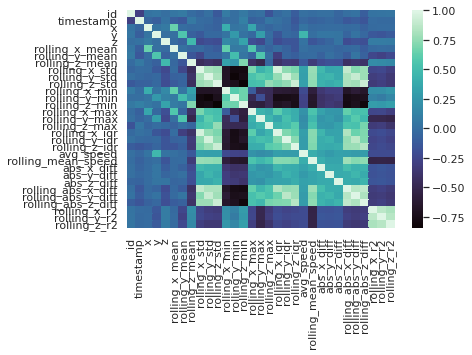

In [119]:
corr = final.corr()
seaborn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap="mako")

In [19]:
def get_all_model_results(features):
  train, test, y_train, y_test = train_test_split(final[features], final['class'], stratify=final['class'])

  dt = tree.DecisionTreeClassifier()
  dt.fit(train, y_train)
  dt_frame = generate_all_stats(dt, train, y_train, test, y_test)
  print("Decision Tree")
  print(dt_frame)

  nb = GaussianNB()
  nb.fit(train, y_train)
  nb_frame = generate_all_stats(nb, train, y_train, test, y_test)
  print("Naive Bayes")
  print(nb_frame)

  clf = LogisticRegression(solver='liblinear')
  clf.fit(train, y_train)
  clf_frame = generate_all_stats(clf, train, y_train, test, y_test)
  print("Logistic")
  print(clf_frame)

  lsvm = SVC(kernel="linear", C=0.025)
  lsvm.fit(train, y_train)
  lsvm_frame = generate_all_stats(lsvm, train, y_train, test, y_test)
  print("Linear SVM")
  print(lsvm_frame)

  rbfsvm = SVC(gamma=2, C=1)
  rbfsvm.fit(train, y_train)
  rbfsvm_frame = generate_all_stats(rbfsvm, train, y_train, test, y_test)
  print("RBF SVM")
  print(rbfsvm_frame)

  nn = KNeighborsClassifier(3)
  nn.fit(train, y_train)
  nn_frame = generate_all_stats(nn, train, y_train, test, y_test)
  print("Nearest Neighbor")
  print(nn_frame)

  gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=1, random_state=0)
  gb.fit(train, y_train)
  gb_frame = generate_all_stats(gb, train, y_train, test, y_test)
  print("Gradient Boosting")
  print(gb_frame)

  rf = RandomForestClassifier(max_depth=5, n_estimators=10)
  rf.fit(train, y_train)
  rf_frame = generate_all_stats(rf, train, y_train, test, y_test)
  print("Random Forest")
  print(rf_frame)

  ada = AdaBoostClassifier()
  ada.fit(train, y_train)
  ada_frame = generate_all_stats(ada, train, y_train, test, y_test)
  print("AdaBoost")
  print(ada_frame)

In [20]:
features = ['x','y','z','rolling_x_min', 'rolling_y_min', 
            'rolling_z_min','rolling_x_max', 'rolling_y_max', 'rolling_z_max']
get_all_model_results(features)

Decision Tree
             train      test
Accuracy  0.999705  0.832547
F1        0.999753  0.796112
Naive Bayes
             train      test
Accuracy  0.715030  0.717276
F1        0.600471  0.602804
Logistic
             train      test
Accuracy  0.736263  0.730542
F1        0.585667  0.592293
Linear SVM
             train      test
Accuracy  0.747272  0.742630
F1        0.582302  0.583837
RBF SVM
             train      test
Accuracy  0.999705  0.461675
F1        0.999753  0.373565
Nearest Neighbor
             train      test
Accuracy  0.915561  0.846698
F1        0.893350  0.797746
Gradient Boosting
             train      test
Accuracy  0.758478  0.755601
F1        0.613936  0.611613
Random Forest
             train      test
Accuracy  0.784429  0.780366
F1        0.642633  0.637301
AdaBoost
             train      test
Accuracy  0.674236  0.668927
F1        0.575909  0.576810


Running x,y,z on all models to select promising ones. 
Candidate Methods:
- Decision Tree
- Nearest Neighbor 
- RBF SVM (fluctuates)
- Gradient Boosting (needs fine tunnning) 
- Random Forest (needs fine tunnning) 

# Fine-tunning Decision Tree

In [111]:
train, test, y_train, y_test = train_test_split(final[_features], final['class'], stratify=final['class'])

dt = tree.DecisionTreeClassifier(max_depth=18)
dt.fit(train, y_train)
dt_frame = generate_all_stats(dt, train, y_train, test, y_test)
print("Decision Tree")
print(dt_frame)

Decision Tree
             train      test
Accuracy  0.992628  0.890920
F1        0.991650  0.855427


In [99]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []

for depth in [2,4,6,8,10,12,14,16,18,20]:
  print("Testing max depth ... "+str(depth))
  dt = tree.DecisionTreeClassifier(max_depth=depth)
  dt.fit(train, y_train)
  dt_frame = generate_all_stats(dt, train, y_train, test, y_test)
  train_acc.append(dt_frame['train'][0])
  train_f1.append(dt_frame['train'][1])
  test_acc.append(dt_frame['test'][0])
  test_f1.append(dt_frame['test'][1])

Testing max depth ... 2
Testing max depth ... 4
Testing max depth ... 6
Testing max depth ... 8
Testing max depth ... 10
Testing max depth ... 12
Testing max depth ... 14
Testing max depth ... 16
Testing max depth ... 18
Testing max depth ... 20


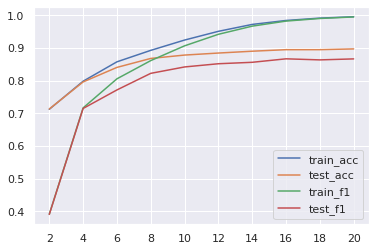

In [100]:
plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.plot(train_f1, label="train_f1")
plt.plot(test_f1, label="test_f1")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[2,4,6,8,10,12,14,16,18,20])
plt.legend()
plt.show()

optimal parameter: 16 

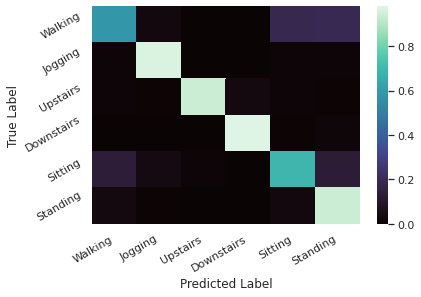

In [117]:
def get_confusion_heatmap(clf, test, y_test):
  y_pred = clf.predict(test)
  cf_matrix = confusion_matrix(y_test, y_pred)
  cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

  seaborn.set(font_scale=1.0)
  ax = seaborn.heatmap(cf_matrix, cmap="mako")
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)
  plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
  ax.set(ylabel="True Label", xlabel="Predicted Label")

dt = tree.DecisionTreeClassifier(max_depth=16)
dt.fit(train, y_train)
get_confusion_heatmap(dt, test, y_test)

# Fine-tunning Nearest Neighbors


In [113]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []

for k in [2,3,4,5,6,7,8,9,10]:
  print("Testing k neighbors ..." + str(k))
  nn = KNeighborsClassifier(n_neighbors=k)
  nn.fit(train, y_train)
  nn_frame = generate_all_stats(nn, train, y_train, test, y_test)
  train_acc.append(nn_frame['train'][0])
  train_f1.append(nn_frame['train'][1])
  test_acc.append(nn_frame['test'][0])
  test_f1.append(nn_frame['test'][1])

Testing k neighbors ...2
Testing k neighbors ...3
Testing k neighbors ...4
Testing k neighbors ...5
Testing k neighbors ...6
Testing k neighbors ...7
Testing k neighbors ...8
Testing k neighbors ...9
Testing k neighbors ...10


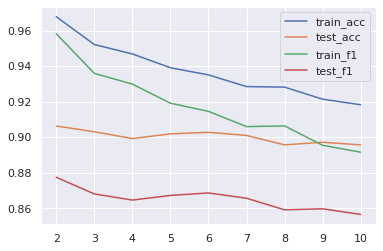

In [115]:
plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.plot(train_f1, label="train_f1")
plt.plot(test_f1, label="test_f1")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels=[2,3,4,5,6,7,8,9,10])
plt.legend()
plt.show()

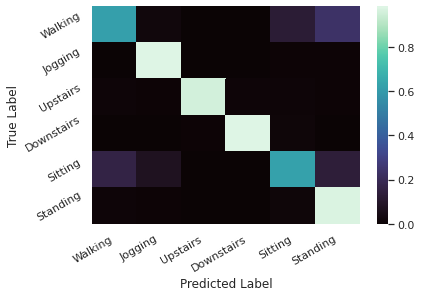

In [118]:
nn = KNeighborsClassifier(6)
nn.fit(train, y_train)
get_confusion_heatmap(nn, test, y_test)

# Fine-tunning Gradient Boosting

In [94]:
train_acc = []
train_f1 = []
test_acc = []
test_f1 = []

for depth in range(1,7):  
  gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=depth, random_state=0)
  print("Testing max depth ... "+str(depth))
  gb.fit(train, y_train)
  gb_frame = generate_all_stats(gb, train, y_train, test, y_test)
  train_acc.append(gb_frame['train'][0])
  train_f1.append(gb_frame['train'][1])
  test_acc.append(gb_frame['test'][0])
  test_f1.append(gb_frame['test'][1])

Testing max depth ... 1
Testing max depth ... 2
Testing max depth ... 3
Testing max depth ... 4
Testing max depth ... 5
Testing max depth ... 6


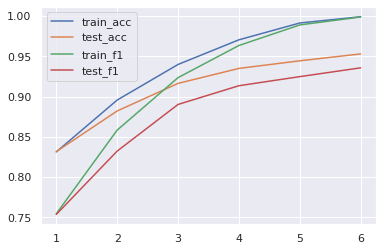

In [98]:
plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.plot(train_f1, label="train_f1")
plt.plot(test_f1, label="test_f1")
plt.xticks(ticks=[0,1,2,3,4,5], labels=[1,2,3,4,5,6])
plt.legend()
plt.show()

optimal parameter max_depth = 6 ?

Testing n = 50, learning rate = 0.3
Testing n = 50, learning rate = 0.25
Testing n = 50, learning rate = 0.2
Testing n = 50, learning rate = 0.15
Testing n = 50, learning rate = 0.1
Testing n = 50, learning rate = 0.05


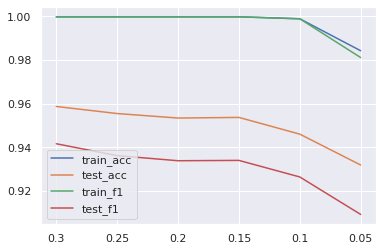

Testing n = 100, learning rate = 0.3
Testing n = 100, learning rate = 0.25
Testing n = 100, learning rate = 0.2
Testing n = 100, learning rate = 0.15
Testing n = 100, learning rate = 0.1
Testing n = 100, learning rate = 0.05


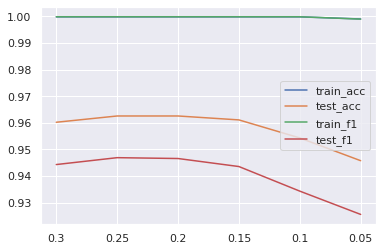

Testing n = 200, learning rate = 0.3
Testing n = 200, learning rate = 0.25
Testing n = 200, learning rate = 0.2
Testing n = 200, learning rate = 0.15
Testing n = 200, learning rate = 0.1
Testing n = 200, learning rate = 0.05


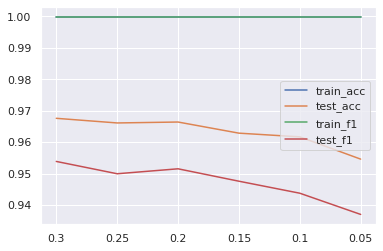

In [112]:

for n in [50, 100, 200]:
  train_acc_ = []
  train_f1_ = []
  test_acc_ = []
  test_f1_ = []

  for lr in [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]: 
    print("Testing n = {n}, learning rate = {lr}".format(n=str(n), lr=str(lr)))
    gb = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, max_depth=6, random_state=0)
    gb.fit(train, y_train)
    gb_frame = generate_all_stats(gb, train, y_train, test, y_test)
    train_acc_.append(gb_frame['train'][0])
    train_f1_.append(gb_frame['train'][1])
    test_acc_.append(gb_frame['test'][0])
    test_f1_.append(gb_frame['test'][1])

  plt.plot(train_acc_, label="train_acc")
  plt.plot(test_acc_, label="test_acc")
  plt.plot(train_f1_, label="train_f1")
  plt.plot(test_f1_, label="test_f1")
  plt.xticks(ticks=[0,1,2,3,4,5], labels=[0.3, 0.25, 0.2, 0.15, 0.1, 0.05])
  plt.legend()
  plt.show()